In [1]:
import re
from statistics import mean, stdev
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_score, recall_score, accuracy_score, precision_recall_curve, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from functions.formatting import snake_to_title_case
from functions.data import numerical_features, make_confusion_matrix
from functions.plotting.mpl import plot_empty, plot_heatmap, plot_barh

In [2]:
save=True

# Get Data

In [3]:
# Import
records_df = pd.read_csv('data/physics.csv')
transforms_df = pd.read_csv('data/physics-transforms.csv')
df = records_df.join(transforms_df.set_index('id_'), on='id_', how='left')
df = df[numerical_features]

# Random Forest

In [4]:
# Used for K-fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
scaler = StandardScaler()
ros = RandomOverSampler(random_state=0)

In [5]:
# Choose features
features_list = ['gpa', 'gre_verbal', 'gre_quantitative', 'gre_writing_pctl', 'gre_subject',
                 'american', 'papers', 'research',]
target = 'decision'

In [6]:
# Set aside 20% of data for final test, should predict Decision, because we want to study effects of each
features_train_all_df, features_test_all_df, target_train_ser, target_test_ser = train_test_split(
    df.drop(columns = [target]), df[target], test_size=.2, random_state=42)

features_train_chosen_df = features_train_all_df[features_list]
features_test_chosen_df = features_test_all_df[features_list]
features_train_chosen_array = np.array(features_train_chosen_df)
target_train_array = np.array(target_train_ser)

In [7]:
rf_clf = RandomForestClassifier(random_state = 71)

# Collect the cross-validation results
cv_f1_list, roc_auc_list = [], []

for train_index, val_cv_index in kf.split(features_train_chosen_array, target_train_array):

    # Make the split
    features_train_cv_array, target_train_cv_array = features_train_chosen_array[train_index], target_train_array[train_index]
    features_val_cv_array, target_val_cv_array = features_train_chosen_array[val_cv_index], target_train_array[val_cv_index] 
    
    # Rebalance train features, no need to rebalance validation set, resample is better than smote
    features_train_cv_resampled_array, target_train_cv_resampled_array = ros.fit_sample(features_train_cv_array, target_train_cv_array)
    features_train_cv_resampled_scaled_array = scaler.fit_transform(features_train_cv_resampled_array)  # Scale resampled features
    features_val_cv_scaled_array = scaler.transform(features_val_cv_array)  # Scale validation features

    rf_clf.fit(features_train_cv_resampled_scaled_array, target_train_cv_resampled_array) # Fit model
    cv_f1_list.append(f1_score(rf_clf.predict(features_val_cv_scaled_array), target_val_cv_array)) # Collect results
    roc_auc_list.append(roc_auc_score(target_val_cv_array, rf_clf.predict_proba(features_val_cv_scaled_array)[:,1])) # Collect results

print('train_f1_score: ', mean(cv_f1_list),' +/- ', stdev(cv_f1_list))
print('train_roc_auc_score: ', mean(roc_auc_list),' +/- ', stdev(roc_auc_list))

# Final train and test

# Rebalance train features, no need to rebalance validation set, resample is better than smote
features_train_resampled_array, target_train_resampled_array = ros.fit_sample(features_train_chosen_array, target_train_array)
features_train_resampled_scaled_array = scaler.fit_transform(features_train_resampled_array) # Scale features
features_test_scaled_array = scaler.transform(features_test_chosen_df) # Scale features

rf_clf.fit(features_train_resampled_scaled_array, target_train_resampled_array) # Fit model
rf_fpr, rf_tpr, rf_thresholds = roc_curve(target_test_ser, rf_clf.predict_proba(features_test_scaled_array)[:,1]) # For later

print("test_f1_score = ", f1_score(rf_clf.predict(features_test_scaled_array), target_test_ser))
print("test_roc_auc_score = ", roc_auc_score(target_test_ser, rf_clf.predict_proba(features_test_scaled_array)[:,1]))
print("test_accuracy_score = ", accuracy_score(target_test_ser, rf_clf.predict(features_test_scaled_array)))

train_f1_score:  0.587668797456722  +/-  0.037129289557921816
train_roc_auc_score:  0.6774378826953819  +/-  0.01887994226495785
test_f1_score =  0.6246575342465754
test_roc_auc_score =  0.7039133914391827
test_accuracy_score =  0.6579275905118602


# Tune Parameters

In [8]:
# Optimize max depth

max_depth_list = range(1, 26)
train_f1_score_list, train_roc_auc_score_list, train_accuracy_list = [], [], []
test_f1_score_list, test_roc_auc_score_list, test_accuracy_list = [], [], []

for i in max_depth_list:

    rf_clf = RandomForestClassifier(max_depth = i, random_state = 71)

    # Final train and test

    # Rebalance train features, no need to rebalance validation set, resample is better than smote
    features_train_resampled_array, target_train_resampled_array = ros.fit_sample(features_train_chosen_array, target_train_array)
    features_train_resampled_scaled_array = scaler.fit_transform(features_train_resampled_array) # Scale features
    features_test_scaled_array = scaler.transform(features_test_chosen_df) # Scale features

    rf_clf.fit(features_train_resampled_scaled_array, target_train_resampled_array) # Fit model
    rf_fpr, rf_tpr, rf_thresholds = roc_curve(target_test_ser, rf_clf.predict_proba(features_test_scaled_array)[:,1]) # For later

    train_f1_score_list.append(f1_score(rf_clf.predict(features_train_resampled_scaled_array), target_train_resampled_array))
    train_roc_auc_score_list.append(roc_auc_score(target_train_resampled_array, rf_clf.predict_proba(features_train_resampled_scaled_array)[:,1]))
    train_accuracy_list.append(accuracy_score(target_train_resampled_array, rf_clf.predict(features_train_resampled_scaled_array)))
    test_f1_score_list.append(f1_score(rf_clf.predict(features_test_scaled_array), target_test_ser))
    test_roc_auc_score_list.append(roc_auc_score(target_test_ser, rf_clf.predict_proba(features_test_scaled_array)[:,1]))
    test_accuracy_list.append(accuracy_score(target_test_ser, rf_clf.predict(features_test_scaled_array)))


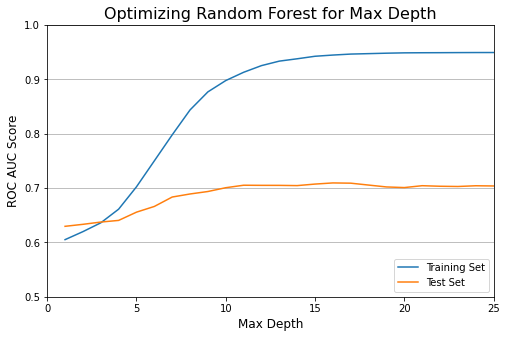

In [9]:
# Plot results
fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(max_depth_list, train_roc_auc_score_list, label = "Training Set")
plt.plot(max_depth_list, test_roc_auc_score_list, label = "Test Set")
ax.set_xlabel('Max Depth', fontsize=12)
ax.set_ylabel('ROC AUC Score', fontsize=12)
ax.set_xlim(left = 0, right = 25)
ax.set_ylim(bottom = 0.5, top = 1)
ax.yaxis.grid(True)
plt.legend(loc='lower right')
plt.title('Optimizing Random Forest for Max Depth', fontsize=16)
if save:
    plt.savefig("figures/random-forest/max-depth.png", transparent=False, bbox_inches="tight")

In [10]:
# Optimize number of trees

n_estimators_list = range(1, 30)
train_f1_score_list, train_roc_auc_score_list, train_accuracy_list = [], [], []
test_f1_score_list, test_roc_auc_score_list, test_accuracy_list = [], [], []

for i in n_estimators_list:

    rf_clf = RandomForestClassifier(n_estimators = i, max_depth = 13, random_state = 71)

    # Final train and test

    # Rebalance train features, no need to rebalance validation set, resample is better than smote
    features_train_resampled_array, target_train_resampled_array = ros.fit_sample(features_train_chosen_array, target_train_array)
    features_train_resampled_scaled_array = scaler.fit_transform(features_train_resampled_array) # Scale features
    features_test_scaled_array = scaler.transform(features_test_chosen_df) # Scale features

    rf_clf.fit(features_train_resampled_scaled_array, target_train_resampled_array) # Fit model
    rf_fpr, rf_tpr, rf_thresholds = roc_curve(target_test_ser, rf_clf.predict_proba(features_test_scaled_array)[:,1]) # For later

    train_f1_score_list.append(f1_score(rf_clf.predict(features_train_resampled_scaled_array), target_train_resampled_array))
    train_roc_auc_score_list.append(roc_auc_score(target_train_resampled_array, rf_clf.predict_proba(features_train_resampled_scaled_array)[:,1]))
    train_accuracy_list.append(accuracy_score(target_train_resampled_array, rf_clf.predict(features_train_resampled_scaled_array)))
    test_f1_score_list.append(f1_score(rf_clf.predict(features_test_scaled_array), target_test_ser))
    test_roc_auc_score_list.append(roc_auc_score(target_test_ser, rf_clf.predict_proba(features_test_scaled_array)[:,1]))
    test_accuracy_list.append(accuracy_score(target_test_ser, rf_clf.predict(features_test_scaled_array)))


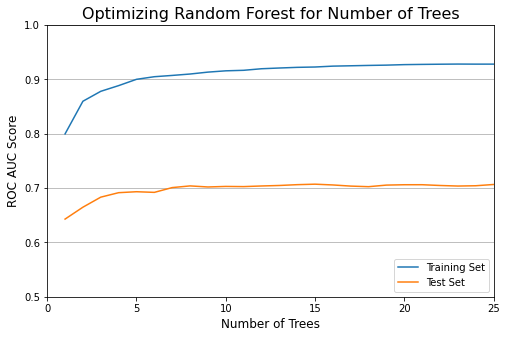

In [11]:
# Plot results
fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(n_estimators_list, train_roc_auc_score_list, label = "Training Set")
plt.plot(n_estimators_list, test_roc_auc_score_list, label = "Test Set")
ax.set_xlabel('Number of Trees', fontsize=12)
ax.set_ylabel('ROC AUC Score', fontsize=12)
ax.set_xlim(left = 0, right = 25)
ax.set_ylim(bottom = 0.5, top = 1)
ax.yaxis.grid(True)
plt.legend(loc='lower right')
plt.title('Optimizing Random Forest for Number of Trees', fontsize=16)
if save:
    plt.savefig("figures/random-forest/number-of-trees.png", transparent=False, bbox_inches="tight")

# Optimized Random Forest

In [12]:
rf_clf = RandomForestClassifier(max_depth = 13, n_estimators = 8, random_state = 71)

# Collect the cross-validation results
cv_f1_list, roc_auc_list = [], []

for train_index, val_cv_index in kf.split(features_train_chosen_array, target_train_array):

    # Make the split
    features_train_cv_array, target_train_cv_array = features_train_chosen_array[train_index], target_train_array[train_index]
    features_val_cv_array, target_val_cv_array = features_train_chosen_array[val_cv_index], target_train_array[val_cv_index] 
    
    # Rebalance train features, no need to rebalance validation set, resample is better than smote
    features_train_cv_resampled_array, target_train_cv_resampled_array = ros.fit_sample(features_train_cv_array, target_train_cv_array)
    features_train_cv_resampled_scaled_array = scaler.fit_transform(features_train_cv_resampled_array)  # Scale resampled features
    features_val_cv_scaled_array = scaler.transform(features_val_cv_array)  # Scale validation features

    rf_clf.fit(features_train_cv_resampled_scaled_array, target_train_cv_resampled_array) # Fit model
    cv_f1_list.append(f1_score(rf_clf.predict(features_val_cv_scaled_array), target_val_cv_array, average = 'micro')) # Collect results
    roc_auc_list.append(roc_auc_score(target_val_cv_array, rf_clf.predict_proba(features_val_cv_scaled_array)[:,1])) # Collect results

print('train_f1_score: ', mean(cv_f1_list),' +/- ', stdev(cv_f1_list))
print('train_roc_auc_score: ', mean(roc_auc_list),' +/- ', stdev(roc_auc_list))

# Final train and test

# Rebalance train features, no need to rebalance validation set, resample is better than smote
features_train_resampled_array, target_train_resampled_array = ros.fit_sample(features_train_chosen_array, target_train_array)
features_train_resampled_scaled_array = scaler.fit_transform(features_train_resampled_array) # Scale features
features_test_scaled_array = scaler.transform(features_test_chosen_df) # Scale features

rf_clf.fit(features_train_resampled_scaled_array, target_train_resampled_array) # Fit model
rf_fpr, rf_tpr, rf_thresholds = roc_curve(target_test_ser, rf_clf.predict_proba(features_test_scaled_array)[:,1]) # For later

print("test_f1_score = ", f1_score(rf_clf.predict(features_test_scaled_array), target_test_ser, average = 'micro'))
print("test_roc_auc_score = ", roc_auc_score(target_test_ser, rf_clf.predict_proba(features_test_scaled_array)[:,1]))
print("test_accuracy_score = ", accuracy_score(target_test_ser, rf_clf.predict(features_test_scaled_array)))

train_f1_score:  0.6138743174726989  +/-  0.01471408576581624
train_roc_auc_score:  0.6641286096250937  +/-  0.016094033876368447
test_f1_score =  0.6441947565543071
test_roc_auc_score =  0.7039852943015418
test_accuracy_score =  0.6441947565543071


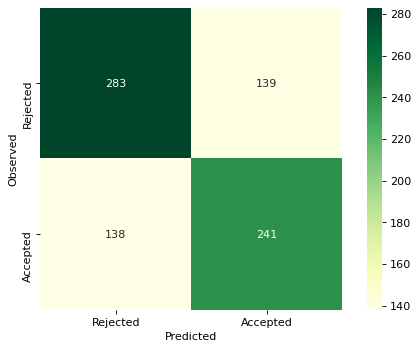

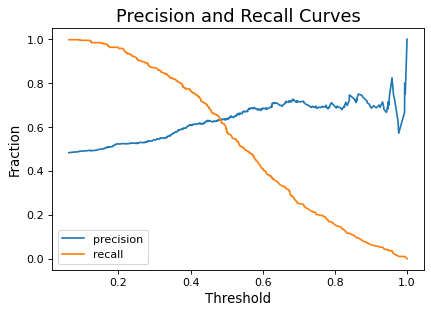

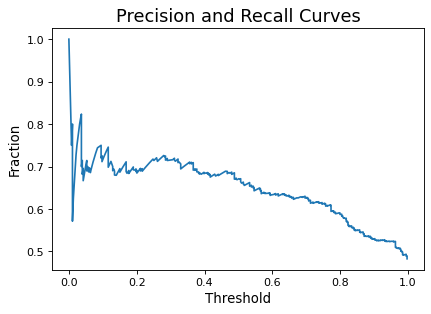

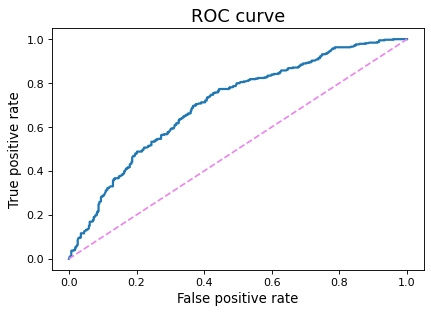

In [13]:
# Confusion Matrix
confusion = make_confusion_matrix(rf_clf, features_test_scaled_array, target_test_ser, threshold=0.481)
fig, ax = plot_heatmap(confusion,
                       xlabel='Predicted', ylabel='Observed',
                       xticklabels=['Rejected', 'Accepted'],
                       yticklabels=['Rejected', 'Accepted'],
                       color='YlGn'
                      )
if save:
    plt.savefig("figures/random-forest-optimized/confusion.png", transparent=True, bbox_inches="tight")


# Precision and recall curve
precision_curve, recall_curve, threshold_curve = precision_recall_curve(target_test_ser, rf_clf.predict_proba(features_test_scaled_array)[:,1])
fig = plot_empty(xlabel='Threshold', ylabel='Fraction', title='Precision and Recall Curves', figsize=None)
plt.plot(threshold_curve, precision_curve[1:], label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')

if save:
    plt.savefig("figures/random-forest-optimized/precision-and-recall.png", transparent=True, bbox_inches="tight")


# Precision-recall curve
fig = plot_empty(xlabel='Threshold', ylabel='Fraction', title='Precision and Recall Curves', figsize=None)
plt.plot(recall_curve[1:], precision_curve[1:], label='precision')
if save:
    plt.savefig("figures/random-forest-optimized/precision-recall.png", transparent=True, bbox_inches="tight")
    
    
# ROC Curve
fpr, tpr, thresholds = roc_curve(target_test_ser, rf_clf.predict_proba(features_test_scaled_array)[:,1])
fig = plot_empty(xlabel='False positive rate', ylabel='True positive rate', title='ROC curve', figsize=None)
plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
if save:
    plt.savefig("figures/random-forest-optimized/roc.png", transparent=True, bbox_inches="tight")

# Feature Importance

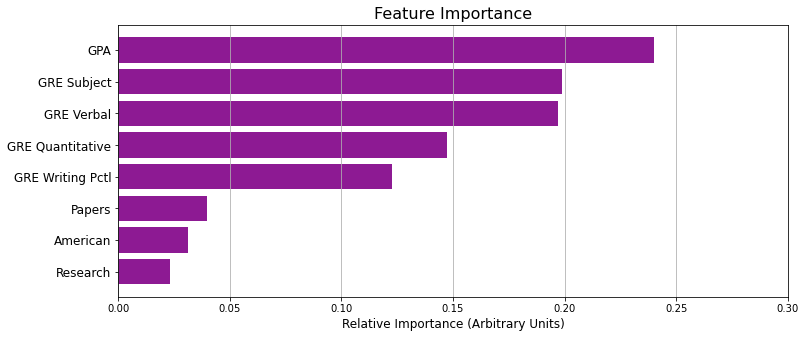

In [16]:
# Plot feature importance
bar_df = pd.DataFrame({
    "feature": features_train_chosen_df.columns,
    "feature_importance": rf_clf.feature_importances_,
}).sort_values("feature_importance").reset_index(drop=True)
bar_df['feature'] = bar_df['feature'].apply(snake_to_title_case)
bar_df['feature'] = bar_df['feature'].apply(lambda x: re.sub('Gpa', 'GPA', x)).apply(lambda x: re.sub('Gre', 'GRE', x))

fig, ax = plot_barh(bar_df, 'feature_importance', 'feature',
                    xlabel='Relative Importance (Arbitrary Units)',
                    title='Feature Importance',
                    figsize=(12, 5))
ax.set_xlim(0, 0.3)
ax.xaxis.grid(True)
if save:
    plt.savefig("figures/random-forest/feature-importance.png", transparent=True, bbox_inches="tight")